### Neuron Model
**The microcircuits of striatum in silico**

### Network List

- SPN (done)
- FS (in-progress)


In [1]:
pip install neuron

Note: you may need to restart the kernel to use updated packages.


In [1]:
### Library
from brian2 import *
import brian2 as br
from brian2tools import *
import matplotlib.pyplot as pltㅋ
import random
import numpy as np
from brian2.units import *
from neuron import h, gui
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
import json
import numpy as np

pS = siemens * 1e-12

--No graphics will be displayed.


### Model 1: Quadratic Integrate and Fire (SPN)

- construct dSPN, iSPN
- V: membrane potential 
- u: neuron's slow current
- I<sub>spon</sub>: 뉴런 내부의 활동 반영 (represents the intrinsic spontaneous current with the neuron)
- I<sub>stim</sub>: externally applied stimulus current, which in this context would include the cortical input
- I<sub>syn</sub>: This current arises from synaptic inputs received by the neuron from other neurons within the network (include GABAergic inputs, Glutamatergic inputs)

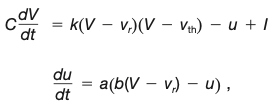

In [2]:
### SPN Neuron Model 
# D1(SD1) - dSPN, D2 - iSPN

def Neuron_dSPN():

    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C + sigma_msn*xi/ms**.5 : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop1) : volt
    K = k*(1-ALPHA*Dop2) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn : amp
    Dop1      : 1
    Dop2      : 1
    '''

    dSPN = NeuronGroup(N, model=eqs,
                       threshold='v > vpeak',
                       reset='v = c; u += d',
                       method='euler')
    E_L = -74.2 * br.mV
    # dSPN.v = E_L 

    ##dSPN.g_ex = 0 * br.siemens
    #dSPN.g_in = 0 * br.siemens
    #dSPN.w = 0 * br.amp
    #dSPN.ex_input = 0 * br.second
    #dSPN.in_input = 0 * br.second
    return dSPN

In [3]:
def Neuron_iSPN():
    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop2) : volt
    K = k*(1-ALPHA*Dop1) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn    : amp
    Dop1    : 1
    Dop2    : 1
    '''
# not consider sigma_msn

    iSPN = NeuronGroup(N, model=eqs,
                       threshold='v > vpeak',
                       reset='v = c; u += d',
                       method='euler')
    # E_L = -74.2 * mV
    # iSPN.v = E_L 

    return iSPN

In [4]:
# Neuron parameters 
# Fountas, Zafeirios. "Action selection in the rhythmic brain: The role of the basal ganglia and tremor." PhD Thesis, Imperial College London (2016).

a = 0.01 / br.ms
b = -20 / br.ms
c = -55 * br.mV
d = 91 * br.mV / br.ms
vpeak = 4. * br.mV
vr = -80 * mV
vt = -29.7 * br.mV
C = 15.2 * br.pF 
v = -80 * br.mV
u = 0.0 * br.mV
Ispon = 0.0 * br.mV
K = 0.0289
L = 0.331

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
HTA = 0.1       # Humphries 2014
EPSILON = 0.625 # Humphries 2014
BITA1 = 0.5     # Humphries 2014
BITA2 = 0.3     # Humphries 2014
        
sigma_msn = 14.0 * br.mV
N = 10000

INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_u5ib47jv/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_u5ib47jv/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_u5ib47jv/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_u5ib47jv/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_u5ib47jv/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_u5ib47jv/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_u5ib47jv
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

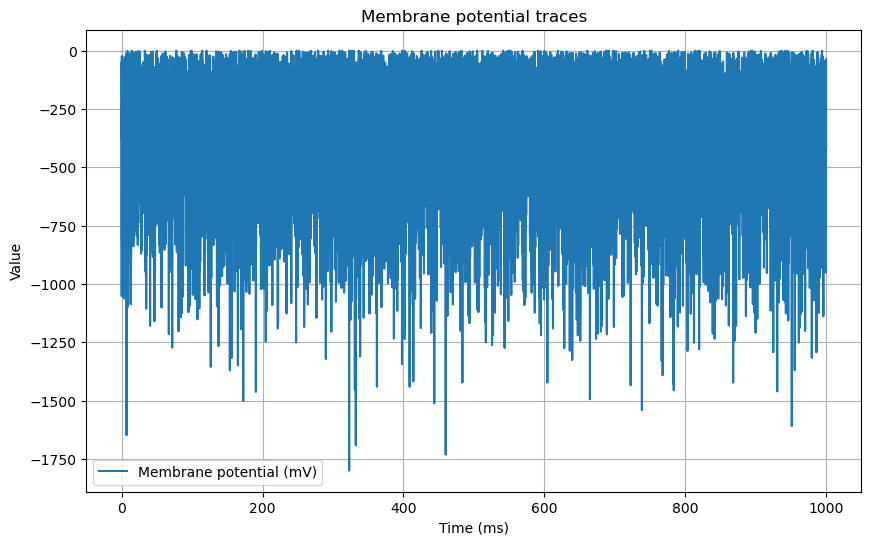

In [5]:
### Simulation 

dSPN_group = Neuron_dSPN()

# Run the simulation
simulation_time = 1000 * ms
defaultclock.dt = 0.1 * ms  # Set the integration time step
run(simulation_time)

# Extract membrane potential traces
v = dSPN_group.v / mV

# Generate the time array
t = np.arange(0, simulation_time / ms, defaultclock.dt / ms)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, v, label='Membrane potential (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Value')
plt.title('Membrane potential traces')
plt.legend()
plt.grid(True)
plt.show()

### Model 2: Quadratic Integrate and Fire (FS)

In [6]:
# parameters

sigma_fsi = 4.6*mV 

a = 0.2 / br.ms
b = -0.025 / br.ms
c = -60 / br.mV
d = 0.0 * br.mV / br.ms
vpeak = 25 * br.mV
vr = -70 * mV
vt = -50 * br.mV
C = 80.0 * br.pF 
v = -70 * br.mV
u = 0.0 * br.mV
Ispon = 0.0 * br.mV
k = 1.0
L = 0.331
vb = -55.0 * br.mV
hta = 0.1
epsilon = 0.625 * br.mV

KAPA = 0.0289   # Humphries etal 2009a
ALPHA = 0.032   # Humphries etal 2009a
HTA = 0.1       # Humphries 2014
EPSILON = 0.625 # Humphries 2014
BITA1 = 0.5     # Humphries 2014
BITA2 = 0.3     # Humphries 2014

In [7]:
def Neuron_FS(N):

    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C + sigma_msn*xi/ms**.5 : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop1) : volt
    K = k*(1-ALPHA*Dop2) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    C       : pF
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn = Igaba_MSN + Igaba_FSI + Iampa*(1.0 - BITA2*Dop2) + Inmda*(1.0 + BITA1*Dop1): amp
    Dop1      : 1
    Dop2      : 1
    '''
# not consider sigma_msn

    FS = NeuronGroup(N, model=eqs,
                       threshold='v > vpeak',
                       reset='v = c; u += d',
                       method='euler')
    E_L = -74.2 * mV
    FS.v = E_L 
    
    return FS

### Connect Synapse

In [8]:
### Load synaptic parameter
data = dict()
data["MSN"] = dict()
data["MSN"]["tau"] = {
    "AMPA" :   { "value" : 6 * ms, "unit" : "ms"},
    "NMDA" :   { "value" : 160 * ms, "unit" : "ms"},
    "GABA" :   { "value" : 4 * ms, "unit" : "ms"}
}
data["MSN"]["E"] = {
    "AMPA" :   { "value" : 0 * mV, "unit" : "mV"},
    "NMDA" :   { "value" : 0 * mV, "unit" : "mV"},
    "GABA" :   { "value" : -60 * mV, "unit" : "mV"},
}
data["MSN"]["G"] = {
    "Ctx-MSN" : {
        "AMPA":   { "value" : 0.6, "unit" : "nS"},
        "NMDA":   { "value" : 0.3, "unit" : "nS"},
        "GABA":   { "value" : 0.0, "unit" : "nS"},
    },
    "MSN-MSN" : {
        "AMPA":   { "value" : 0.0, "unit" : "nS"},
        "NMDA":   { "value" : 0.0, "unit" : "nS"},
        "GABA":   { "value" : 0.75, "unit" : "nS"},
    },
    "FSI-MSN" : {
        "AMPA":   { "value" : 0.0, "unit" : "nS"},
        "NMDA":   { "value" : 0.0, "unit" : "nS"},
        "GABA":   { "value" : 3.75, "unit" : "nS"},
    }
}

N = 10000
tau_ampa = 6 * ms / 1000
tau_nmda = 160 * ms / 1000
tau_gaba = 4 * ms / 1000
theta_syn = -50 * mV
E_syn = -80 * mV

In [9]:
# load parameter value & model

connect_probability = {
    'pSP1SP1': 0.26,
    'pSP1SP2': 0.06,
    'pSP2SP1': 0.28,
    'pSP2SP2': 0.36,
    'pFSFS': 0.58,      
}

# respectively distance 100um 
connect_probability_100 = {
    'pSP1SP1': 0.07,
    'pSP1SP2': 0.04,
    'pSP2SP1': 0.23,
    'pSP2SP2': 0.13,
    'pFSFS': 0.58,
    'pFSSP1': 0.89,
    'pFSSP2': 0.67      
}

# 함수 저장
model_functions = {
    'Neuron_dSPN': Neuron_dSPN,
    'Neuron_iSPN': Neuron_iSPN,
    #'Neuron_FS': Neuron_FS
}

In [10]:
### Synapse Connection
# Hjorth, JJ Johannes, et al. "The microcircuits of striatum in silico." Proceedings of the National Academy of Sciences 117.17 (2020): 9554-9565.

def connect(source, target, model, p_connect=0.1, pre = ''):
    synapse = Synapses(source, target, model=model, pre = pre)
    synapse.connect(p=p_connect)
    return synapse

dSPN = model_functions['Neuron_dSPN']()
iSPN = model_functions['Neuron_iSPN']()

syn_eqs_SPN = '''
    B = 1.0/(1.0+(0.28)*exp(-0.062*v/mV)) : 1

    Iampa     = G_ampa*g_ampa*(E_ampa-v): amp
    Inmda     = B*G_nmda*g_nmda*(E_nmda-v) : amp
    Igaba_MSN = G_gaba_MSN*g_gaba_MSN*(E_gaba-v) : amp
    Igaba_FSI = G_gaba_FSI*g_gaba_FSI*(E_gaba-v) : amp

    dg_ampa/dt = -g_ampa/tau_ampa : siemens
    dg_nmda/dt = -g_nmda/tau_nmda : siemens
    dg_gaba_MSN/dt = -g_gaba_MSN/tau_gaba : siemens
    dg_gaba_FSI/dt = -g_gaba_FSI/tau_gaba : siemens
    tau_ampa   : second
    tau_nmda   : second
    tau_gaba   : second
    E_ampa     : volt
    E_nmda     : volt
    E_gaba     : volt
    G_ampa     : 1
    G_nmda     : 1
    G_gaba_MSN : 1
    G_gaba_FSI : 1
    '''

syn_eqs_FS = '''
    B = 1.0/(1.0+(0.28)*exp(-0.062*v/mV)) : 1

    Iampa     = G_ampa*g_ampa*(E_ampa-v): amp
    Inmda     = B*G_nmda*g_nmda*(E_nmda-v) : amp
    Igaba_MSN = G_gaba_MSN*g_gaba_MSN*(E_gaba-v) : amp
    Igaba_FSI = G_gaba_FSI*g_gaba_FSI*(E_gaba-v) : amp

    dg_ampa/dt = -g_ampa/tau_ampa : siemens
    dg_nmda/dt = -g_nmda/tau_nmda : siemens
    dg_gaba_MSN/dt = -g_gaba_MSN/tau_gaba : siemens
    dg_gaba_FSI/dt = -g_gaba_FSI/tau_gaba : siemens

    tau_ampa   : second
    tau_nmda   : second
    tau_gaba   : second
    E_ampa     : volt
    E_nmda     : volt
    E_gaba     : volt
    G_ampa     : 1
    G_nmda     : 1
    G_gaba_MSN : 1
    G_gaba_FSI : 1
    '''

syn_dSPN_dSPN = connect(dSPN, dSPN, syn_eqs_SPN, p_connect = connect_probability.get('pSP1SP1'), pre = "g_gaba_MSN+=0.4*nS")
syn_dSPN_iSPN = connect(dSPN, iSPN, syn_eqs_SPN, p_connect = connect_probability.get('pSP1SP2'), pre = "g_gaba_MSN+=1.0*nS")
syn_iSPN_dSPN = connect(iSPN, dSPN, syn_eqs_SPN, p_connect = connect_probability.get('pSP2SP1'), pre = "g_gaba_MSN+=1.2*nS")
syn_iSPN_iSPN = connect(iSPN, iSPN, syn_eqs_SPN, p_connect = connect_probability.get('pSP2SP2'), pre = "g_gaba_MSN+=1.0*nS")

WARNING    The 'pre' keyword is deprecated, use 'on_pre' instead. [brian2.synapses.synapses.deprecated_pre]


INFO       The synaptic equation for the variable g_ampa does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable g_gaba_FSI does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable g_gaba_MSN does not specify whethe

In [11]:
### Generate Synapse 

synapse_functions = {
    'syn_dSPN_dSPN': syn_dSPN_dSPN,
    'syn_iSPN_dSPN': syn_iSPN_dSPN,
    'syn_dSPN_iSPN': syn_dSPN_iSPN,
    'syn_iSPN_iSPN': syn_iSPN_iSPN
}

### Simulation 

In [12]:
def simulation(neuron_models, synapse_models, duration=1000*ms, dt=0.1*ms):
  """
  다양한 뉴런 모델과 시냅스 모델을 사용하여 시뮬레이션을 수행하는 함수입니다.

  Args:
    neuron_models: 시뮬레이션에 사용할 뉴런 모델 목록입니다.
    synapse_models: 시뮬레이션에 사용할 시냅스 모델 목록입니다.
    duration: 시뮬레이션 지속 시간 (ms)입니다.
    dt: 시뮬레이션 시간 간격 (ms)입니다.

  Returns:
    spike history
  """

  # 네트워크 구성
  network = Network()

  # 뉴런 그룹 생성
  for model in neuron_models:
    network.add(model)

  # 시냅스 연결
  for source, target, synapse_model in synapse_models:
    synapse_model.connect()

  # 스파이크 모니터링
  spike_monitors = []
  for model in neuron_models:
    spike_monitor = StateMonitor(model, 'v', record = True)
    spike_monitors.append(spike_monitor)
    network.add(spike_monitor)

  # 시뮬레이션 실행
  network.run(duration)

  # 스파이크 기록 추출
  spike_records = []
  spike_records = [monitor.t for monitor in spike_monitors]

  return spike_records

In [13]:
synapse_models = [
  (dSPN, dSPN, syn_dSPN_dSPN),
  (dSPN, iSPN, syn_dSPN_iSPN),
  (iSPN, dSPN, syn_iSPN_dSPN),
  (iSPN, iSPN, syn_iSPN_iSPN)
]

In [14]:
start_scope()
spike_records = simulation([dSPN, iSPN], synapse_models, duration=1000*ms)

INFO:root:building '_cython_magic_4ebd1233a5199388ca3f8a03763ec6c4' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_4ebd1233a5199388ca3f8a03763ec6c4.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_4ebd1233a5199388ca3f8a03763ec6c4.o -w

### Visualization

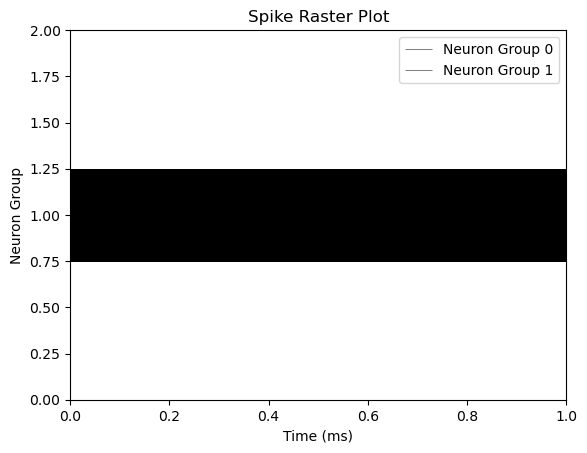

In [15]:
def visualize_spikes(spike_records, duration):
  """
  시뮬레이션 결과의 스파이크 기록을 시각화합니다.

  Args:
    spike_records: 각 뉴런 그룹의 스파이크 기록입니다.
    duration: 시뮬레이션 지속 시간 (ms)입니다.
  """

  # 각 뉴런 그룹의 스파이크 기록을 추출합니다.
  spike_times = [[float(spike_time) for spike_time in group_records] for group_records in spike_records]

  # 라스터 플롯 생성
  for i, spike_time in enumerate(spike_times):
    plt.eventplot(spike_time, linelengths=0.5, linewidths=0.5, color='k', alpha=0.7,
                  label=f'Neuron Group {i}')

  # 라벨과 제목 설정
  plt.xlabel('Time (ms)')
  plt.ylabel('Neuron Group')
  plt.title('Spike Raster Plot')

  # 축 설정
  plt.xlim(0, duration)
  plt.ylim(0, len(spike_records))

  # 범례 표시
  plt.legend()

  # 그래프 표시
  plt.show()


# 스파이크 기록 시각화
visualize_spikes(spike_records, 1000 * ms)

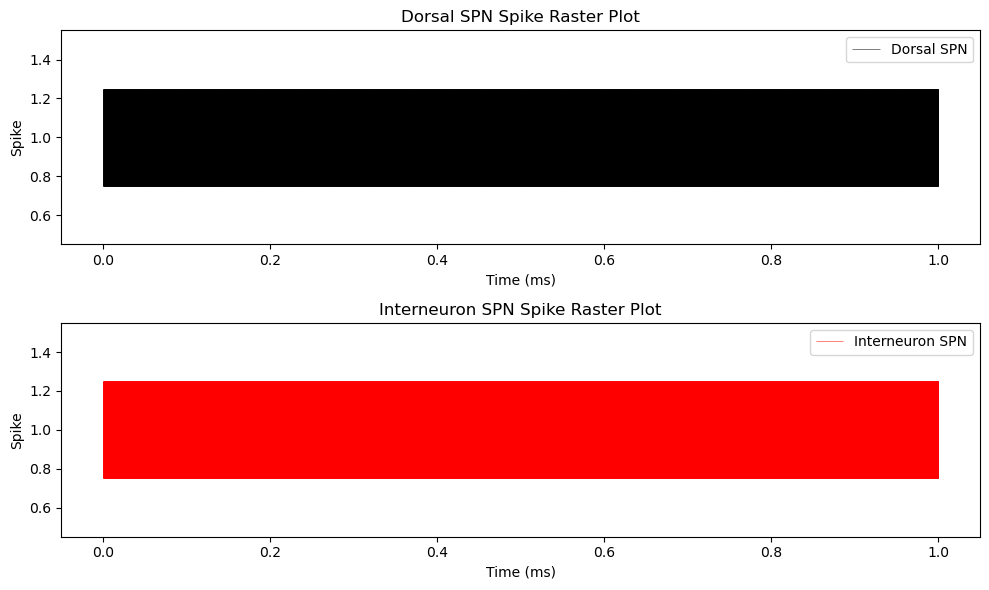

In [16]:
dSPN_spikes = spike_records[0]
iSPN_spikes = spike_records[1]

# Visualize spikes for each neuron group
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.eventplot(dSPN_spikes, linelengths=0.5, linewidths=0.5, color='k', alpha=0.7,
             label='Dorsal SPN')
plt.xlabel('Time (ms)')
plt.ylabel('Spike')
plt.title('Dorsal SPN Spike Raster Plot')
plt.legend()

plt.subplot(2, 1, 2)
plt.eventplot(iSPN_spikes, linelengths=0.5, linewidths=0.5, color='r', alpha=0.7,
             label='Interneuron SPN')
plt.xlabel('Time (ms)')
plt.ylabel('Spike')
plt.title('Interneuron SPN Spike Raster Plot')
plt.legend()

plt.tight_layout()
plt.show()

### Cortex Input

In [17]:
def Neuron_dSPN_ctx():

    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C + sigma_msn*xi/ms**.5 : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop1) : volt
    K = k*(1-ALPHA*Dop2) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn : amp
    Dop1      : 1
    Dop2      : 1
    '''

    dSPN = NeuronGroup(N, model=eqs,
                       threshold='v > vpeak',
                       reset='v = c; u += d',
                       method='euler')
    # E_L = -74.2 * br.mV
    # dSPN.v = E_L 
    dSPN.run_regularly('Istim = input_array(t)', dt=dt*ms)

    ##dSPN.g_ex = 0 * br.siemens
    #dSPN.g_in = 0 * br.siemens
    #dSPN.w = 0 * br.amp
    #dSPN.ex_input = 0 * br.second
    #dSPN.in_input = 0 * br.second
    return dSPN

In [18]:
def Neuron_iSPN_ctx():
    eqs = '''
    dv/dt = (K*1*pF/ms/mV*(v-VR)*(v-vt)-u*pF+I)/C : volt
    du/dt = a*(b*(v-VR)-u) : volt/second
    VR = vr*(1+KAPA*Dop2) : volt
    K = k*(1-ALPHA*Dop1) : 1
    a       : 1/second
    b       : 1/second
    c       : volt
    d       : volt/second
    k       : 1
    vr      : volt
    vt      : volt
    vpeak   : volt
    I = Ispon + Istim + Isyn : amp
    Istim   : amp
    Ispon   : amp
    Isyn    : amp
    Dop1    : 1
    Dop2    : 1
    '''
# not consider sigma_msn

    iSPN = NeuronGroup(N, model=eqs,
                       threshold='v > vpeak',
                       reset='v = c; u += d',
                       method='euler')
    # E_L = -74.2 * mV
    # iSPN.v = E_L 
    iSPN.run_regularly('Istim = input_array(t)', dt=dt*ms)

    return iSPN

In [22]:
def generate_cortex_input(duration, dt):
    t = np.arange(0, duration, dt)  # 시간 배열 생성
    input_values = np.ones_like(t) * 20  # 기본 값으로 초기화
    
    spike_time = 50 
    spike_duration = 20
    spike_value = 90

    spike_indices = np.logical_or(t >= spike_time, t < spike_time + spike_duration)
    for i in range(min(spike_time, len(input_values)), min(spike_time + spike_duration, len(input_values))):
        input_values[i] = spike_value
    input_values = input_values * 1e-9  # Convert to amps
        
    return t * ms, input_values * nA

# Generate cortex input values
duration = 10000  # total duration in ms
dt = 1          # time step in ms

time_array, cortex_input = generate_cortex_input(duration, dt)

# Create a TimedArray with the cortex input, ensuring dt has units of seconds
input_array = TimedArray(cortex_input, dt=dt*ms)

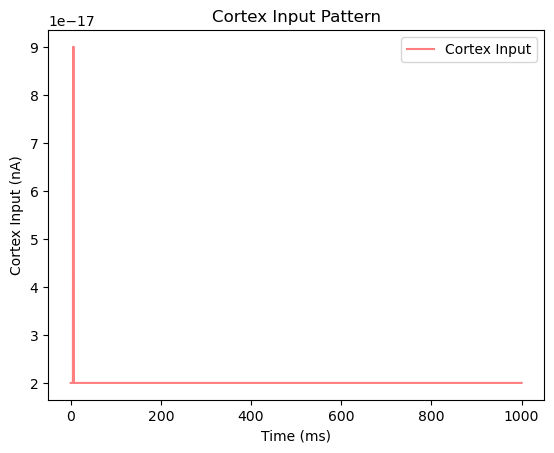

In [23]:
# Cortex 입력 패턴 시각화
plt.plot(t, cortex_input, 'r', alpha=0.5, label='Cortex Input')
plt.xlabel('Time (ms)')
plt.ylabel('Cortex Input (nA)')
plt.title('Cortex Input Pattern')
plt.legend()

In [24]:
# 함수 저장
model_functions_ctx = {
    'Neuron_dSPN_ctx': Neuron_dSPN_ctx,
    'Neuron_iSPN_ctx': Neuron_iSPN_ctx,
}

duration = 10  # total duration in ms

In [25]:
dSPN_ctx = model_functions_ctx['Neuron_dSPN_ctx']()
iSPN_ctx = model_functions_ctx['Neuron_iSPN_ctx']()

In [29]:
def simulation_ctx(neuron_models, synapse_models, cortex_input_array, duration=100*ms, dt=0.1*ms):

    # 네트워크 구성
    network = Network()

  # 뉴런 그룹 생성
    for model in neuron_models:
        network.add(model)

  # 시냅스 연결
    for source, target, synapse_model in synapse_models:
        synapse_model.connect()

    cortex_input = TimedArray(Quantity(cortex_input_array), dt=dt)
    cortex_input_array = cortex_input.values
    time_vec = np.arange(0, duration + dt, dt)
    for t in time_vec:
        current_input = cortex_input_array[int(t)]
        for neuron_group in neuron_models:
            neuron_group.Istim = current_input * amp
            
    # 스파이크 모니터링
    spike_monitors = []
    for model in neuron_models:
        # spike_monitor = SpikeMonitor(model)
        spike_monitor = StateMonitor(model, 'v', record = True)
        spike_monitors.append(spike_monitor)
        network.add(spike_monitor)

    # 시뮬레이션 실행
    network.run(duration)

    # 스파이크 기록 추출
    spike_records = []
    spike_records = [monitor.t for monitor in spike_monitors]

    return spike_records

In [30]:
spike_records = simulation_ctx([dSPN_ctx, iSPN_ctx], synapse_models, cortex_input,
                          duration = duration * ms, dt = dt*ms)

RuntimeError: neurongroup_3 has already been simulated, cannot add it to the network. If you were trying to remove and add an object to temporarily stop it from being run, set its active flag to False instead.

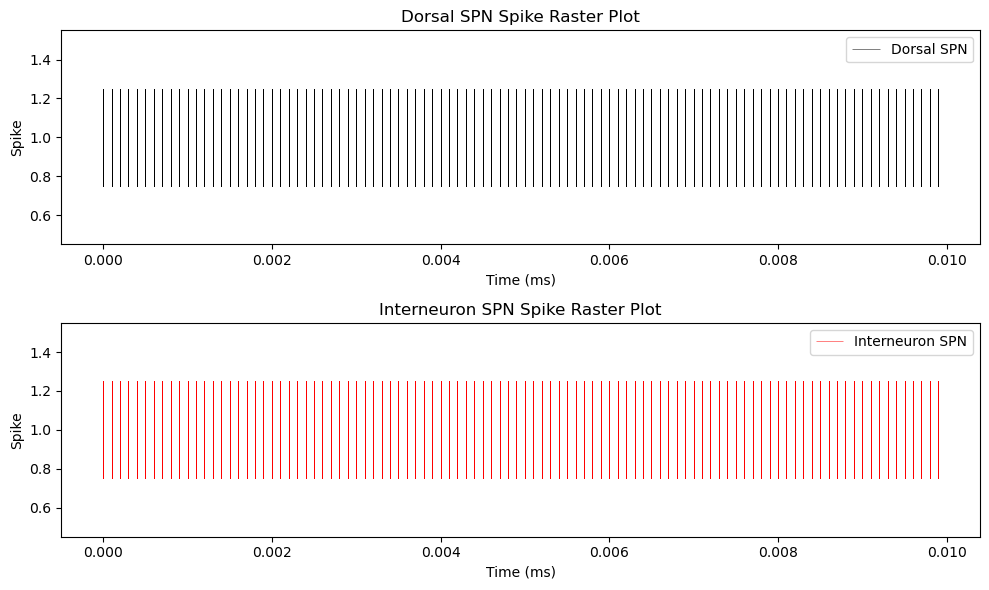

In [28]:
dSPN_spikes = spike_records[0]
iSPN_spikes = spike_records[1]

# Visualize spikes for each neuron group
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.eventplot(dSPN_spikes, linelengths=0.5, linewidths=0.5, color='k', alpha=0.7,
             label='Dorsal SPN')
plt.xlabel('Time (ms)')
plt.ylabel('Spike')
plt.title('Dorsal SPN Spike Raster Plot')
plt.legend()

plt.subplot(2, 1, 2)
plt.eventplot(iSPN_spikes, linelengths=0.5, linewidths=0.5, color='r', alpha=0.7,
             label='Interneuron SPN')
plt.xlabel('Time (ms)')
plt.ylabel('Spike')
plt.title('Interneuron SPN Spike Raster Plot')
plt.legend()

plt.tight_layout()
plt.show()